<a href="https://colab.research.google.com/github/kaitken17/colab_based_projects/blob/master/rnn_rl/rnn_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import random

In [3]:
!pip install tensorflow_text

import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers, stax

import numpy as np
import matplotlib.pyplot as plt

import os
import time
import pickle

import sys
sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/reverse-engineering-neural-networks')
import renn

import gym

from collections import deque # Used to store replay data

     |████████████████████████████████| 3.4MB 8.0MB/s 


In [4]:
# Skips any tests and just runs function definitions
run_tests = False

state_colors = ['firebrick', 'darkgreen', 'blue', 'darkorange', 'm', 'deeppink', 'r', 'gray', 'g', 'navy', 
                'y', 'purple', 'cyan', 'olive', 'skyblue', 'pink', 'tan']
state_colors_light = ['salmon', 'limegreen', 'cornflowerblue', 'bisque', 'plum', 'pink', 'tomato', 'lightgray', 'g', 'b', 
                      'y', 'purple', 'cyan', 'olive', 'skyblue', 'pink', 'tan']

In [5]:


'''
Observation:
    Type: Box(4)
    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole 
                    -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf
Actions:
    Type: Discrete(2)
    Num   Action
    0     Push cart to the left
    1     Push cart to the right
'''

env = gym.make('CartPole-v0')
env.max_episode_steps = 500
action_space = env.action_space.n
state_space = env.observation_space.shape[0]
print('Action space size:', action_space)
print('State space size:', state_space)

def batch_state(state):
    return state.reshape((1,) + state.shape)

Action space size: 2
State space size: 4


In [6]:
time_length = 100
states = np.zeros((time_length+1, 4))

start_state = env.reset()
print('Start state:', start_state)
states[0] = start_state
for idx in range(time_length):
    rand_action = env.action_space.sample()
    next_state, reward, done, _ = env.step(rand_action)
    states[idx+1] = next_state
    print('New state:', next_state, 'Done:', done)


Start state: [-0.0032934  -0.03443375 -0.04539712  0.0245912 ]
New state: [-0.00398207 -0.22887626 -0.04490529  0.30261231] Done: False
New state: [-0.0085596  -0.42333041 -0.03885305  0.58080177] Done: False
New state: [-0.0170262  -0.61788701 -0.02723701  0.86099652] Done: False
New state: [-0.02938394 -0.42240494 -0.01001708  0.55987548] Done: False
New state: [-0.03783204 -0.22714384  0.00118043  0.26405354] Done: False
New state: [-0.04237492 -0.03203875  0.0064615  -0.02825683] Done: False
New state: [-0.04301569  0.16298994  0.00589636 -0.3188941 ] Done: False
New state: [-0.0397559  -0.03221549 -0.00048152 -0.02435752] Done: False
New state: [-0.04040021  0.16291336 -0.00096867 -0.31719234] Done: False
New state: [-0.03714194 -0.03219478 -0.00731252 -0.02481505] Done: False
New state: [-0.03778583 -0.2272111  -0.00780882  0.26555175] Done: False
New state: [-0.04233006 -0.42222073 -0.00249778  0.55576152] Done: False
New state: [-0.05077447 -0.2270638   0.00861745  0.26229269] 

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


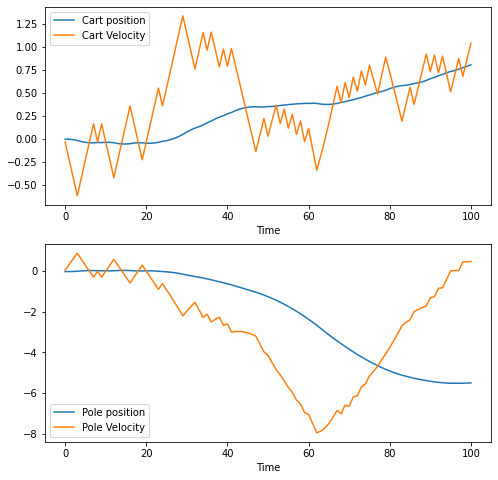

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(np.arange(time_length+1), states[:, 0], label='Cart position')
ax1.plot(np.arange(time_length+1), states[:, 1], label='Cart Velocity')
ax2.plot(np.arange(time_length+1), states[:, 2], label='Pole position')
ax2.plot(np.arange(time_length+1), states[:, 3], label='Pole Velocity')

for ax in (ax1, ax2):
    ax.legend()
    ax.set_xlabel('Time')

In [8]:
run_this = False

if run_this:

    class DQNCartPoleSolver():
        def __init__(self, n_episodes=1000, n_win_ticks=195, max_env_steps=None, gamma=1.0, epsilon=1.0, epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, batch_size=64, monitor=False, quiet=False):
            self.memory = deque(maxlen=100000)
            self.env = gym.make('CartPole-v0')
            if monitor: self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
            self.gamma = gamma
            self.epsilon = epsilon
            self.epsilon_min = epsilon_min
            self.epsilon_decay = epsilon_log_decay
            self.alpha = alpha
            self.alpha_decay = alpha_decay
            self.n_episodes = n_episodes
            self.n_win_ticks = n_win_ticks
            self.batch_size = batch_size
            self.quiet = quiet
            if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

            # Init model
            self.model = Sequential()
            self.model.add(Dense(24, input_dim=4, activation='tanh'))
            self.model.add(Dense(48, activation='tanh'))
            self.model.add(Dense(2, activation='linear'))
            self.model.compile(loss='mse', optimizer=Adam(lr=self.alpha, decay=self.alpha_decay))

        def remember(self, state, action, reward, next_state, done):
            self.memory.append((state, action, reward, next_state, done))

        def choose_action(self, state, epsilon):
            return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.model.predict(state))

        def get_epsilon(self, t):
            return max(self.epsilon_min, min(self.epsilon, 1.0 - np.log10((t + 1) * self.epsilon_decay)))

        def preprocess_state(self, state):
            return np.reshape(state, [1, 4])

        def replay(self, batch_size):
            x_batch, y_batch = [], []
            minibatch = random.sample(
                self.memory, min(len(self.memory), batch_size))
            for state, action, reward, next_state, done in minibatch:
                y_target = self.model.predict(state)
                y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state)[0])
                x_batch.append(state[0])
                y_batch.append(y_target[0])
            
            self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

        def run(self):
            scores = deque(maxlen=100)

            for e in range(self.n_episodes):
                state = self.preprocess_state(self.env.reset())
                done = False
                i = 0
                while not done:
                    action = self.choose_action(state, self.get_epsilon(e))
                    next_state, reward, done, _ = self.env.step(action)
                    next_state = self.preprocess_state(next_state)
                    self.remember(state, action, reward, next_state, done)
                    state = next_state
                    i += 1

                scores.append(i)
                mean_score = np.mean(scores)
                if mean_score >= self.n_win_ticks and e >= 100:
                    if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                    return e - 100
                if e % 100 == 0 and not self.quiet:
                    print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

                self.replay(self.batch_size)
            
            if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
            return e

    if __name__ == '__main__':
        agent = DQNCartPoleSolver()
        agent.run()

### Build RNN Functions

In [124]:
def build_rnn(rnn_specs, env):
    """Builds a single layer RNN (Vanilla/GRU/LSTM/UGRNN with readout)"""

    num_inputs = rnn_specs['input_size']
    num_units = rnn_specs['hidden_size']
    num_outputs = rnn_specs['output_size']

    # Build the RNN cell.
    if rnn_specs['cell_type'] == 'Vanilla':
        cell = renn.rnn.cells.VanillaRNN(num_units)
    elif rnn_specs['cell_type'] == 'GRU':
        cell = renn.rnn.cells.GRU(num_units)
    elif rnn_specs['cell_type'] == 'LSTM':
        cell = renn.rnn.cells.LSTM(num_units)
    elif rnn_specs['cell_type'] == 'UGRNN':
        cell = renn.rnn.cells.UGRNN(num_units)
    
    # Initializes readout (with or without bias)
    if rnn_specs['ro_bias']:
        readout_init, readout_apply = stax.Dense(num_outputs)
    else:
        readout_init, readout_apply = Dense_nobias(num_outputs)

    def init_fun(prng_key, input_shape):
        """Initializes the network (the embedding and the RNN cell)."""
        k0, k1 = jax.random.split(prng_key, 2)
        output_shape, rnn_params = cell.init(k0, input_shape[1:])
        # We explicitly add the batch dimension back in.
        # (This is because we only applied `vmap` to the rnn_apply function above)
        batch_output_shape = (input_shape[0],) + output_shape

        _, readout_params = readout_init(k1, output_shape)

        return batch_output_shape, (rnn_params, readout_params)

    def run_fun(prng_key, params, initial_states, returns={}):
        """Runs a batch of episodes by applying the RNN. """
        # Destructure parameter tuple.
        rnn_params, readout_params = params

        prng_key, subkey = jax.random.split(prng_key)

        initial_hidden = cell.get_initial_state(
            rnn_params, batch_size=initial_states.shape[0])

        rnn_update = functools.partial(cell.batch_apply, rnn_params)
        ro_apply_params = functools.partial(readout_apply, readout_params)

        return run_episodes(prng_key, env, initial_states, initial_hidden, rnn_update, 
                            ro_apply_params, rnn_specs, returns=returns, 
                            ep_length=rnn_specs['max_episode_steps']) 

    def mask_fun(sequences, last_index):
        """Selects the last valid timestep from a batch of padded sequences."""
        last_index = last_index[:, :, jnp.newaxis]
        return jnp.take_along_axis(sequences, last_index, axis=1)

    def sigmoid_xent_with_logits(logits, labels):
        return jnp.maximum(logits, 0) - logits * labels + \
            jnp.log(1 + jnp.exp(-jnp.abs(logits)))

    def loss_fun_pg(prng_key, params, initial_states):
        """Cross-entropy loss function for policy gradient training"""

        def xe_loss_fn_pg(logits, actions, rewards):
            """
            Uses rewards to weight NLL loss of actions taken
            Contains both log softmax and negative log liklihood loss.
            """
            # Calculates values of states
            state_values = jnp.matmul(rewards, gamma_cumsum_mat(rnn_specs['gamma'], rewards.shape[-1]))

            # Shifts maximum to zero
            shifted = logits - jax.lax.stop_gradient(logits.max(axis=-1, keepdims=True))
            log_probs = shifted - jnp.log(jnp.sum(jnp.exp(shifted), axis=-1, keepdims=True))

            logliklihood = jnp.take_along_axis(log_probs, jnp.expand_dims(actions, axis=2), axis=2)

            # Scales loglikliehood by state_values
            logliklihood_values = jax.lax.stop_gradient(state_values[:, :, jnp.newaxis]) * logliklihood

            xe_loss = -1 * jnp.mean(logliklihood_values)

            return xe_loss

        logits, actions, states, rewards = run_fun(prng_key, params, initial_states)

        flatten = lambda params: jax.flatten_util.ravel_pytree(params)[0]
        l2_loss = train_params['l2reg'] * np.sum(flatten(params)**2)
        xe_loss = xe_loss_fn_pg(logits, actions, rewards)
        
        loss = l2_loss + xe_loss

        return loss

    def loss_fun_replay(prng_key, params, batch):
        """Cross-entropy loss function for policy gradient training"""

        def xe_loss_fn_replay(logits, y_batch):
            """
            Normal cross-entropy loss for replay
            """
            logits = jnp.squeeze(logits) # Removes time_step dimension

            # Shifts maximum to zero
            shifted = logits - jax.lax.stop_gradient(logits.max(axis=-1, keepdims=True))
            log_probs = shifted - jnp.log(jnp.sum(jnp.exp(shifted), axis=-1, keepdims=True))

            labels_max = jnp.argmax(y_batch, axis=-1)
            logliklihood = jnp.take_along_axis(log_probs, jnp.expand_dims(labels_max, axis=-1), axis=-1)
            xe_loss = -1 * jnp.mean(logliklihood)

            return xe_loss

        def mse_loss_fn_replay(logits, y_batch):
            """
            Normal cross-entropy loss for replay
            """
            logits = jnp.squeeze(logits) # Removes time_step dimension

            mse = (logits - y_batch)**2
            mse_loss = jnp.mean(mse)

            return mse_loss

        x_batch, y_batch = batch
        initial_states, initial_hidden = x_batch

        logits, *_ = predict(params, initial_states, initial_hidden)

        flatten = lambda params: jax.flatten_util.ravel_pytree(params)[0]
        l2_loss = train_params['l2reg'] * np.sum(flatten(params)**2)
        
        # xe_loss = xe_loss_fn_replay(logits, y_batch)
        # loss = l2_loss + xe_loss

        mse_loss = mse_loss_fn_replay(logits, y_batch)
        loss = l2_loss + mse_loss

        return loss

    @jax.jit
    def get_rewards(params, initial_states):
        _, _, _, rewards = run_fun(prng_key, params, initial_states)
        return np.sum(rewards, axis=-1)

    @jax.jit
    def get_replay(params, initial_states):
        _, actions, next_states, rewards, hiddens, prev_hiddens, done, states = run_fun(
            prng_key, params, initial_states, returns={
                'hidden', 'prev_hidden', 'done', 'prev_state'})
        return actions, next_states, rewards, hiddens, prev_hiddens, done, states

    @jax.jit
    def predict(params, initial_states, initial_hidden):
        seed = np.random.randint(0, 999999) #342343
        prng_key = jax.random.PRNGKey(seed) 
        
        """ Single step run for predicting given state and hidden """
        # Destructure parameter tuple.
        rnn_params, readout_params = params
        rnn_update = functools.partial(cell.batch_apply, rnn_params)
        ro_apply_params = functools.partial(readout_apply, readout_params)

        return run_episodes(prng_key, env, initial_states, initial_hidden, rnn_update, 
                            ro_apply_params, rnn_specs, returns={}, 
                            ep_length=1)
    
        # return _predict_nojit(prng_key, params, initial_states, initial_hidden, returns)
    
    if rnn_specs['train_mode'] in ('PG',):
        loss_fun = loss_fun_pg
    elif rnn_specs['train_mode'] in ('replay'):
        loss_fun = loss_fun_replay

    return init_fun, run_fun, mask_fun, loss_fun, get_rewards, get_replay, predict


def build_optimizer_step(optimizer, initial_params, loss_fun, gradient_clip=None):
    """Builds training step function."""

    # Destructure the optimizer triple.
    init_opt, update_opt, get_params = optimizer
    opt_state = init_opt(initial_params)

    @jax.jit
    def optimizer_step_noclip(prng_key, batch_data, current_step, state):
        """Takes a single optimization step."""
        p = get_params(state) 
        loss, gradients = jax.value_and_grad(loss_fun, argnums=1)(prng_key, p, batch_data)
        new_state = update_opt(current_step, gradients, state)
        return current_step + 1, new_state, loss

    @jax.jit
    def optimizer_step_clip(prng_key, batch_data, current_step, state):
        """
        Takes a single optimization step.
        batch_data: initial states for 'PG', x_batch and y_batch for 'replay'
        """
        p = get_params(state)
        loss, gradients = jax.value_and_grad(loss_fun, argnums=1)(prng_key, p, batch_data)
        
        gradients = optimizers.clip_grads(gradients, gradient_clip)
        new_state = update_opt(current_step, gradients, state)
        return current_step + 1, new_state, loss    
    if gradient_clip is None:
        return opt_state, optimizer_step_noclip
    else:
        return opt_state, optimizer_step_clip

def Dense_nobias(out_dim, W_init=jax.nn.initializers.glorot_normal()):
    """Layer constructor function for a dense (fully-connected) layer without bias."""
    def init_fun(rng, input_shape):
        output_shape = input_shape[:-1] + (out_dim,)
        k1, _ = jax.random.split(rng)
        # W = W_init(k1, (input_shape[-1], out_dim))
        W = jnp.zeros((input_shape[-1], out_dim)) # Inits as zeros
        return output_shape, (W)
    def apply_fun(params, inputs, **kwargs):
        W = params
        return jnp.dot(inputs, W)
    return init_fun, apply_fun

def rewards_fun(params, initial_states, get_rewards):
    _rewards = get_rewards(params, initial_states)

    return np.mean(_rewards)

def train_with_environment(prng_key, opt_state, step_fun, get_params, train_params, 
                           rnn_specs, get_rewards, get_replay=None, 
                           predict_fun=None):
    """ Generate sythetic and test data and train for some number of epochs"""
    
    global_step = train_params['global_step']
    total_steps = train_params['total_steps']
    train_losses = train_params['train_losses']
    decay_fun = train_params['decay_fun']
    print_every = train_params['print_every']
    batch_size = train_params['batch_size']

    memory = deque(maxlen=100000)

    for episode in range(train_params['n_episodes']):

        start_time = time.time()  
        avg_loss = 0 
        
        rnn_specs['epsilon'] = max(train_params['epsilon_min'], 
                                   min(train_params['epsilon'] , 
                                       train_params['epsilon_decay']**episode))

        # print('Decay factor', train_params['epsilon'] * train_params['epsilon_decay']**(global_step))

        prng_key, subkey = jax.random.split(prng_key)
        initial_states = jax.random.uniform(subkey, (train_params['batch_size'], 4), minval=-0.05, maxval=0.05)

        prng_key, subkey = jax.random.split(prng_key)
        if train_params['train_mode'] in ('PG',): # Policy gradient training
            global_step, opt_state, loss = step_fun(subkey, initial_states, global_step, opt_state)
        elif train_params['train_mode'] in ('replay',): # Replay training
            # Adds to memory
            actions, next_states, rewards, next_hiddens, hiddens, done, states = get_replay(get_params(opt_state), initial_states)

            actions = actions.reshape((actions.shape[0]*actions.shape[1],))
            next_states = np.vstack(next_states)
            rewards = rewards.reshape((rewards.shape[0]*rewards.shape[1],))
            next_hiddens = np.vstack(next_hiddens)
            hiddens = np.vstack(hiddens)
            done = done.reshape((done.shape[0]*done.shape[1],))
            states = np.vstack(states)
            memory = states, hiddens, actions, rewards, next_states, next_hiddens, done
            
            # # Divides up by batch
            # for state_b, hidden_b, action_b, reward_b, next_state_b, next_hidden_b, done_val_b in zip(
            #     states, hiddens, actions, rewards, next_states, next_hiddens, done):
            #     # Divides up by sequence location
            #     for state, hidden, action, reward, next_state, next_hidden, done_val in zip(
            #         state_b, hidden_b, action_b, reward_b, next_state_b, next_hidden_b, done_val_b):
            #         memory.append((state, hidden, action, reward, next_state, next_hidden, done_val))

            batch_data = build_replay_batch(get_params(opt_state), memory, predict_fun, train_params)

            global_step, opt_state, loss = step_fun(subkey, batch_data, global_step, opt_state)

        train_losses.append(loss)
        avg_loss += loss

        if (global_step+1) % print_every == 0:
            prng_key, subkey = jax.random.split(prng_key)
            initial_states_test = jax.random.uniform(subkey, (100, 4), minval=-0.05, maxval=0.05)
            avg_total_reward = rewards_fun(get_params(opt_state), initial_states_test, get_rewards)
            batch_time = time.time() - start_time
            step_size = decay_fun(global_step)
            s = "Step {} in {:0.2f} sec, step size: {:0.5f}, epsilon: {:0.5f}, total_reward {:0.4f}, avg training loss {:0.4f}"
            print(s.format(global_step+1, batch_time, step_size, rnn_specs['epsilon'], avg_total_reward, avg_loss/print_every))
            start_time = time.time()
            avg_loss = 0
  
    train_params['global_step'] = global_step
    train_params['train_losses'] = train_losses

    return opt_state, train_params

def default_params(train_params, rnn_specs):

    if 'cell_type' not in rnn_specs: rnn_specs['cell_type'] = 'GRU'
    if 'l2reg' not in rnn_specs: rnn_specs['l2reg'] = train_params['l2reg']
    if 'batch_size' not in rnn_specs: rnn_specs['batch_size'] = train_params['batch_size']
    if 'gamma' not in rnn_specs: rnn_specs['gamma'] = train_params['gamma']
    if 'epsilon' not in rnn_specs: rnn_specs['epsilon'] = train_params['epsilon']
    if 'train_mode' not in rnn_specs: rnn_specs['train_mode'] = train_params['train_mode']

    return train_params, rnn_specs

def gamma_cumsum_mat(gamma, size):
    ''' Creates matrix for doing gamma-weighted cumulative sum'''
    state_value_mat = np.zeros((size, size))
    for i in range(state_value_mat.shape[0]):
        for j in range(state_value_mat.shape[1]):
            if i >= j:
                state_value_mat[i,j] = 1 * gamma**(i-j)
            else:
                state_value_mat[i,j] = 0
    return jnp.array(state_value_mat)

def build_replay_batch(params, memory, predict_fun, train_params):
    x_batch, y_batch = [], []
    states, hiddens, actions, rewards, next_states, next_hiddens, done = memory

    rand_idxs = np.random.choice(states.shape[0], min(train_params['batch_size'], states.shape[0]), replace=False)
    batch_states = jnp.array(states[rand_idxs, :])
    batch_next_states = jnp.array(next_states[rand_idxs, :])
    batch_hiddens = jnp.array(hiddens[rand_idxs, :])
    batch_next_hiddens = jnp.array(next_hiddens[rand_idxs, :])

    y_targets, *_ = predict_fun(params, batch_states, batch_hiddens)
    y_targets_next, *_ = predict_fun(params, batch_next_states, batch_next_hiddens)

    y_targets = np.array(y_targets)
    y_targets_next = np.array(y_targets_next)

    idxs = np.arange(train_params['batch_size'])

    y_targets[idxs, 0, actions[rand_idxs]] = rewards[rand_idxs] + (1-done[rand_idxs]) * train_params['gamma'] * np.max(y_targets_next, axis=-1)[:, 0]
    x_batch = jnp.array(states[rand_idxs]), jnp.array(hiddens[rand_idxs])
    y_batch = jnp.array(y_targets[:, 0, :])

    return x_batch, y_batch

    # minibatch = random.sample(
    #     memory, min(len(memory), train_params['batch_size']))
    # for state, hidden, action, reward, next_state, next_hidden, done in minibatch:        
    #     print('state', state.shape)
    #     print('hidden', hidden.shape)
    #     print('reward', reward.shape)
    #     print('done', done.shape)

    #     y_target, *_ = predict_fun(prng_key, params, state[jnp.newaxis, :], hidden[jnp.newaxis, :])
    #     y_target_next, *_ = predict_fun(prng_key, params, next_state[jnp.newaxis, :], next_hidden[jnp.newaxis, :]) 

    #     print('y_target', y_target.shape)
    #     y_target = np.array(y_target)
    #     y_target[0, 0, action] = reward if done else reward + train_params['gamma'] * np.max(
    #         np.array(y_target_next)[0, 0])
    #     x_batch.append(state)
    #     y_batch.append(y_target[0, 0])

    # return jnp.array(x_batch), jnp.array(y_batch)

### Apply Tests

In [14]:
def identity(x):
    """Identity function f(x) = x."""
    return x

def run_episodes(prng_key, env, initial_state, initial_hidden, rnn_update, 
                 readout_apply=identity, rnn_specs={}, returns={}, 
                 ep_length=100):
    """ 
    RNN apply function that interfaces with environment
    
    env: the environment
    initial_state: shape (batch_size, input_dim)
    initial_hidden: shape (batch_size, hidden_size)
    
    """
    
    if rnn_specs['cell_type'] != 'LSTM': # Keeping all of the hidden state for non-LSTM
        hidden_state_keep = initial_hidden.shape[-1]
    else: # For LSTM, we only send the first half of the "hidden state" to the readout, because this corresponds to the true hidden state (i.e. not the cell part)
        hidden_state_keep = int(1/2*initial_hidden.shape[-1])

    def choose_action(prng_key, state, logits, epsilon):
        """ Chooses the action with epsilon-greedly policy """
        k1, k2 = jax.random.split(prng_key)
        if np.random.random() <= epsilon:
        # if jax.random.uniform(k1) <= epsilon:
            return jax.random.randint(k2, (initial_hidden.shape[0],), 0, rnn_specs['output_size'])
        # return np.random.randint(rnn_specs['output_size'], size=(initial_hidden.shape[0]))
        else:
            return jnp.argmax(logits, axis=-1)

    def _step(carry, _):
        """ RNN step, next state's input is determined by the environment. """
        key, prev_hidden, state, is_done = carry
        
        if rnn_specs['hs_mask'] is not None: # Masks state to hide information from RNN
            state_mask = jnp.repeat(rnn_specs['hs_mask'][jnp.newaxis, :], state.shape[0], axis=0)
            next_hidden = rnn_update(state_mask * state, prev_hidden)
        else:
            next_hidden = rnn_update(state, prev_hidden)
        outputs = readout_apply(next_hidden[:, :hidden_state_keep])
        
        # Now that predicted output is, determines action and passes to env       
        key, subkey = jax.random.split(key)
        action = choose_action(subkey, state, outputs, rnn_specs['epsilon'])

        next_state, reward, done, _ = env.step(state, action)

        carry = key, next_hidden, next_state, is_done
        
        is_done = jnp.logical_or(is_done, done)

        # Constructs outputs, which could be many things depending on desired return
        if returns == {}:
            return carry, (outputs, action, next_state, reward)
            # return carry, next_state
        else:
            outs = [outputs, action, next_state, reward]
            if 'hidden' in returns: outs.append(next_hidden)
            if 'prev_hidden' in returns: outs.append(prev_hidden)
            if 'done' in returns: outs.append(is_done)
            if 'prev_state' in returns: outs.append(state)

            return carry, tuple(outs)
    
    is_done = np.zeros(initial_hidden.shape[0], dtype=np.bool) # (batch_size)
    initial_carry = (prng_key, initial_hidden, initial_state, is_done)

    #### Run rnn steps ####

    null_input = jnp.zeros((ep_length))

    # Keeps inputs and potential positional encoding values separate so EoS character still identifiable
    # _, scan_outs = scan(_step, initial_carry, null_input)
    _, scan_outs = jax.lax.scan(_step, initial_carry, null_input)
    
    # Handles different types of returns
    if returns == {}: # Only output is raw logits
        logits, actions, states, rewards = scan_outs
        
        # Makes all rewards beyond first time done zero
        rewards = jnp.swapaxes(rewards, 0, 1)
        done_mask = jnp.int32(np.cumsum(rewards - 1, axis=1) >= 0)
        # rewards = 2 * (rewards * done_mask) - 1
        rewards = rewards * done_mask

        return jnp.swapaxes(logits, 0, 1), jnp.swapaxes(actions, 0, 1), jnp.swapaxes(states, 0, 1), rewards
        # return jnp.swapaxes(states, 0, 1)
    else:
        rewards = jnp.swapaxes(scan_outs[3], 0, 1) 
        rewards = rewards * jnp.int32(np.cumsum(rewards - 1, axis=1) >= 0)

        outs = [jnp.swapaxes(scan_outs[0], 0, 1), jnp.swapaxes(scan_outs[1], 0, 1), jnp.swapaxes(scan_outs[2], 0, 1), rewards]
        out_idx = 4
        if 'hidden' in returns:
            outs.append(jnp.swapaxes(scan_outs[out_idx], 0, 1))
            out_idx += 1
        if 'prev_hidden' in returns:
            outs.append(jnp.swapaxes(scan_outs[out_idx], 0, 1))
            out_idx += 1
        if 'done' in returns: 
            outs.append(jnp.swapaxes(scan_outs[out_idx], 0, 1))
            out_idx += 1
        if 'prev_state' in returns: 
            outs.append(jnp.swapaxes(scan_outs[out_idx], 0, 1))
            out_idx += 1
        return tuple(outs)

In [57]:
seed = 342345
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

########## Environment init ##########

# env = gym.make('CartPole-v0')
# action_space_dim = env.action_space.n
# state_space_dim = env.observation_space.shape[0]

env = CartPoleEnv()
action_space_dim = 2
state_space_dim = 4

env.max_episode_steps = 500
max_episode_steps = 100

########## RNN hyperparameters ##########
rnn_specs = {
    'cell_type': 'GRU',                              # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
    'input_size': state_space_dim,                   # Number of inputs to the RNN
    'hidden_size': 128,                              # Number of units in the RNN
    'output_size': action_space_dim,                 # Number of outputs in the RNN
    'ro_bias': False,                                # Include a bias with the readout
    'max_episode_steps': max_episode_steps,           # 
}

########## Train hyperparameters ##########

train_params = {
    'batch_size': 5,                     # How many examples in each batch
    'num_batchs': 1,                    # Total number of batches to train on.
    'l2reg': 1e-5,           # amount of L2 regularization on the weights
    'gamma': 0.9,
    'epsilon': 0.1,
}

train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] 
train_params, rnn_specs = default_params(train_params, rnn_specs)

# Generate the data to run through the RNN
print('State space dimensions:', state_space_dim)
print('Action space dimensions:', action_space_dim)

# Initialize the optimizer.
init_fun, run_fun, mask_fun, loss_fun, accuracy_fun, get_replay, predict_fun = build_rnn(rnn_specs, env)
input_shape = (train_params['batch_size'], max_episode_steps, state_space_dim)
output_shape, initial_params = init_fun(prng_key, input_shape)

rnn_params, readout_params = initial_params

initial_states = jax.random.uniform(prng_key, (train_params['batch_size'], 4), minval=-0.05, maxval=0.05)

# cell = build_cell(rnn_specs)
outs = run_fun(prng_key, initial_params, initial_states)
out_logits, actions, states, rewards = outs
# states = outs

print('Output logits shape:', out_logits.shape)
print('Output logits:', out_logits)
print('States shape:', states.shape)
print('Output rewards shape:', rewards.shape)
print('Rewards:', rewards)

gamma = 0.9
state_values = np.matmul(rewards, gamma_cumsum_mat(gamma, rewards.shape[-1]))
print(state_values[1])

State space dimensions: 4
Action space dimensions: 2


KeyError: ignored

In [ ]:
batch_idx = 0 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(np.arange(max_episode_steps), states[batch_idx, :, 0], label='Cart position')
ax1.plot(np.arange(max_episode_steps), states[batch_idx, :, 1], label='Cart Velocity')
ax2.plot(np.arange(max_episode_steps), states[batch_idx, :, 2], label='Pole position')
ax2.plot(np.arange(max_episode_steps), states[batch_idx, :, 3], label='Pole Velocity')

for ax in (ax1, ax2):
    ax.legend()
    ax.set_xlabel('Time')

### Train

In [143]:
print('Using random seed.')
seed = np.random.randint(0, 999999) #342343
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

########## Environment init ##########

env = CartPoleEnv()
# env = CartPoleStayEnv()
action_space_dim = env.action_space
state_space_dim = env.observation_space

env.max_episode_steps = 500
max_episode_steps = 100

########## RNN hyperparameters ##########
rnn_specs = {
    'cell_type': 'GRU',                              # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
    'input_size': state_space_dim,                   # Number of inputs to the RNN
    'hidden_size': 128,                              # Number of units in the RNN
    'output_size': action_space_dim,                 # Number of outputs in the RNN
    'ro_bias': False,                                # Include a bias with the readout
    'max_episode_steps': max_episode_steps,           # 
    'hs_mask': None, #jnp.array([1, 0, 1, 0]),
}

########## Train hyperparameters ##########

train_params = {
    'train_mode': 'replay', # 'PG', 'replay'
    
    'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
    'l2reg': 1e-5,           # amount of L2 regularization on the weights

    'init_lr': 0.01,                     # initial learning rate
    'decay_factor': 0.9997,             # decay the learning rate this much
    'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
    'adam_b2': 0.99,
    'adam_eps': 1e-1,

    'batch_size': 2,                     # How many examples in each batch
    'print_every': 100,                     # Print training informatino every so often

    'n_episodes': 10000,
    
    'gamma': 0.9,
    'epsilon': 1.0,
    'epsilon_min': 0.01,
    'epsilon_decay': 0.995,
}


train_params['decay_fun'] = optimizers.exponential_decay(train_params['init_lr'], decay_steps=1, 
                                                         decay_rate=train_params['decay_factor'])
# Sets default parameters if they weren't set above
train_params, rnn_specs = default_params(train_params, rnn_specs)

########## Run ##########

print('State space dimensions:', state_space_dim)
print('Action space dimensions:', action_space_dim)
if rnn_specs['hs_mask'] is not None: print('State mask:', rnn_specs['hs_mask'])

# save_data = True
# path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/aol_unitype_run8tand3left4twice1_10to15_5datasets_l2is1e-5.pickle'
# save_data = override_data(path, save_data)

# Initialize the optimizer.  Please see jax/experimental/optimizers.py
init_fun, run_fun, mask_fun, loss_fun, get_rewards, get_replay, predict_fun = build_rnn(rnn_specs, env)
input_shape = (train_params['batch_size'], max_episode_steps, state_space_dim)
output_shape, initial_params = init_fun(prng_key, input_shape)

opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

init_opt, update_opt, get_params = opt

train_params['train_losses'] = []
train_params['global_step'] = 0
train_params['total_steps'] = 0

# Run lots of episodes
opt_state, train_params = train_with_environment(
    prng_key, opt_state, step_fun, get_params, train_params, rnn_specs, 
    get_rewards, get_replay=get_replay, predict_fun=predict_fun)

train_params.pop('decay_fun') # Can't pickle with decay fun
# train_build.save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params, save_loss=True, )

# Destructure the trained parameters of the RNN.
final_params = get_params(opt_state)
rnn_params, readout_params = final_params

Using random seed.
State space dimensions: 4
Action space dimensions: 2
Step 100 in 2.62 sec, step size: 0.00971, epsilon: 0.61187, total_reward 22.3100, avg training loss 0.0001
Step 200 in 0.02 sec, step size: 0.00942, epsilon: 0.37066, total_reward 21.7900, avg training loss 0.0027
Step 300 in 0.02 sec, step size: 0.00914, epsilon: 0.22453, total_reward 22.4600, avg training loss 0.0002
Step 400 in 0.02 sec, step size: 0.00887, epsilon: 0.13601, total_reward 22.0300, avg training loss 0.0025
Step 500 in 0.02 sec, step size: 0.00861, epsilon: 0.08239, total_reward 21.3400, avg training loss 0.0023
Step 600 in 0.02 sec, step size: 0.00836, epsilon: 0.04991, total_reward 21.2500, avg training loss 0.0021
Step 700 in 0.02 sec, step size: 0.00811, epsilon: 0.03024, total_reward 21.5200, avg training loss 0.0002
Step 800 in 0.02 sec, step size: 0.00787, epsilon: 0.01832, total_reward 21.2500, avg training loss 0.0023
Step 900 in 0.02 sec, step size: 0.00764, epsilon: 0.01109, total_reward

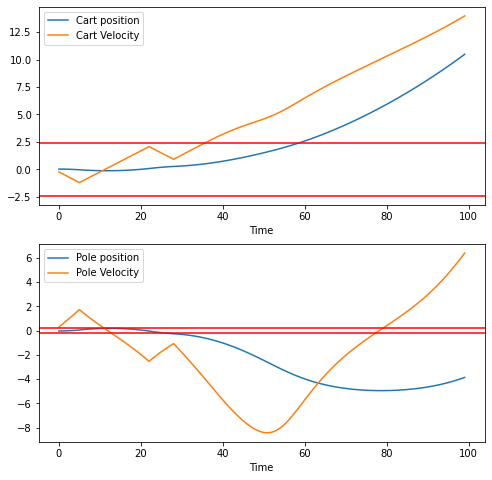

In [142]:
seed = np.random.randint(0, 999999) #342343
prng_key = jax.random.PRNGKey(seed)

n_batch = 1
batch_idx = 0 

initial_states = jax.random.uniform(prng_key, (
    n_batch, rnn_specs['input_size']), 
    minval=-0.05, maxval=0.05)

out_logits, actions, states, rewards = run_fun(prng_key, final_params, initial_states)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(np.arange(max_episode_steps), states[batch_idx, :, 0], label='Cart position')
ax1.plot(np.arange(max_episode_steps), states[batch_idx, :, 1], label='Cart Velocity')
ax2.plot(np.arange(max_episode_steps), states[batch_idx, :, 2], label='Pole position')
ax2.plot(np.arange(max_episode_steps), states[batch_idx, :, 3], label='Pole Velocity')

ax1.axhline(env.x_threshold, color='r')
ax1.axhline(-env.x_threshold, color='r')

ax2.axhline(env.theta_threshold_radians, color='r')
ax2.axhline(-env.theta_threshold_radians, color='r')

for ax in (ax1, ax2):
    ax.legend()
    ax.set_xlabel('Time')

### Network Analysis

In [157]:
# Get RNN hidden states in response to a test batch.
n_trials = 1000

prng_key, subkey = jax.random.split(prng_key)
initial_states = jax.random.uniform(subkey, (n_trials, 4), minval=-0.05, maxval=0.05)

rewards = np.mean(get_rewards(final_params, initial_states))
print('******** Avg Reward:', np.mean(rewards),'********')

out_logits, actions, states, rewards, hs = run_fun(
    prng_key, final_params, initial_states, returns={'hidden',})

if rnn_specs['ro_bias']:
    wO, bO = readout_params
else:
    readout = readout_params.T

******** Avg Reward: 199.014 ********


Top 10 components: 0.9999722431984516 ( [9.87177694e-01 8.24423084e-03 3.02689815e-03 5.40248073e-04
 5.09405817e-04 2.09046884e-04 1.74456376e-04 5.25676584e-05
 2.20941692e-05 1.56017072e-05] )
Readout vec proj via PCA: [[-0.11839566 -0.11391091]
 [-0.3116798   0.32090944]
 [-0.00638086 -0.00597781]
 [ 0.19745313 -0.17430334]
 [ 0.02641403 -0.02115489]
 [ 0.11777985 -0.12898616]
 [-0.06181379  0.05440353]
 [-0.07367466  0.0863438 ]
 [-0.05258573  0.06458236]
 [-0.01364275  0.01416713]]


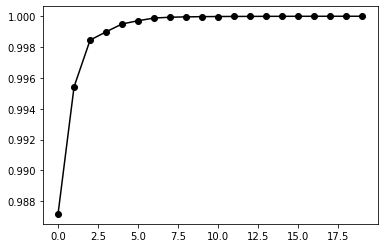

In [158]:
from sklearn.decomposition import PCA

pc_dims = 10

# Finds percentage of variance explained by top pc_dims of PCA
# pca_full = PCA(n_components=rnn_specs['hidden_size'])
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(np.vstack(hs))
explained_var = pca_full.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
total_exvar = []
for i in range(rnn_specs['hidden_size']-1):
    total_exvar.append(np.sum(explained_var[:i+1]))
plt.figure()
plt.plot(total_exvar[:20], 'k-o')

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(np.vstack(hs))
print('Readout vec proj via PCA:', pca.transform(readout).T)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 1.0, 'Colored by: Pole Velocity')

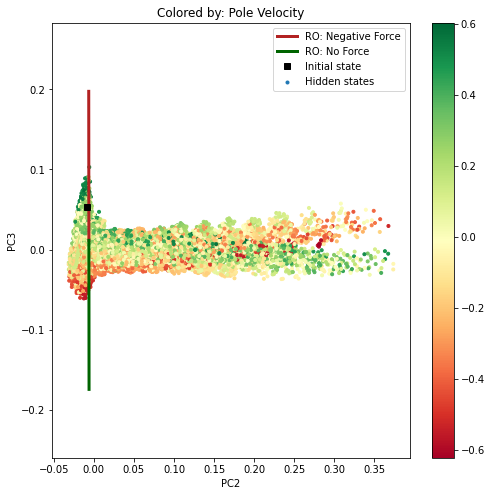

In [163]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

state_labels = ['Cart Position', 'Cart Velocity', 'Pole Position', 'Pole Velocity']
state_color_idx = 3 # 0: cart pos, 1: car vel, 2: pole pos, 3: pole vel
color_vals = np.vstack(states[:, :, state_color_idx])

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

pc1 = 2
pc2 = 3

h0 = rnn_params['initial_state']
pca_h0 = pca.transform(np.atleast_2d(h0)).T

# Plots hidden states as scatter plot
fs_alpha = 1.0
pca_hs = pca.transform(np.vstack(hs)).T
hs_scatter = ax1.scatter(pca_hs[pc1], pca_hs[pc2], c = color_vals, cmap="RdYlGn", marker='.', alpha=fs_alpha, label='Hidden states')

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
# ro_labels = ['Negative Velocity', 'Positive Velocity']
ro_labels = ['Negative Force', 'No Force', 'Positive Force']
for i in range(rnn_specs['output_size']):
    x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
    y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
    ax1.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, label=f'RO: {ro_labels[i]}')

ax1.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

ax1.set_xlabel('PC'+str(pc1))
ax1.set_ylabel('PC'+str(pc2))
# plt_lim = 3
# if plt_lim != None:
#     plt.xlim(-plt_lim, plt_lim)
#     plt.ylim(-plt_lim, plt_lim)

ax1.set_aspect(1.0, adjustable='datalim')
ax1.legend()
fig.colorbar(hs_scatter, ax=ax1)
ax1.set_title(f'Colored by: {state_labels[state_color_idx]}')

#### Fixed Points

In [53]:
def build_cell(rnn_specs):

    print('Using {} cell'.format(rnn_specs['cell_type']))
    if rnn_specs['cell_type'] == 'Vanilla':
        cell = renn.VanillaRNN(rnn_specs['hidden_size'])
    elif rnn_specs['cell_type'] == 'GRU':
        cell = renn.GRU(rnn_specs['hidden_size'])
    elif rnn_specs['cell_type'] == 'LSTM':
        cell = renn.LSTM(rnn_specs['hidden_size'])
    elif rnn_specs['cell_type'] == 'UGRNN':
        cell = renn.UGRNN(rnn_specs['hidden_size'])
    
    if rnn_specs['ro_bias']:
        readout_init, readout_apply = stax.Dense(rnn_specs['output_size'])
    else:
        readout_init, readout_apply = Dense_nobias(rnn_specs['output_size'])

    return cell, readout_apply

In [84]:
add_noise = False
noise_scale = 0.1

fp_input = None  # 0: cart pos, 1: car vel, 2: pole pos, 3: pole vel
if fp_input == None:
    input_val = jnp.zeros(rnn_specs['input_size'])
elif fp_input == 'avg':
    input_val = 1/rnn_specs['input_size']*jnp.ones(rnn_specs['input_size'])
else:
    input_val = np.zeros(rnn_specs['input_size'])
    input_val[fp_input] = 1

seed_pts = np.vstack(hs)[::2] # Every other

xstar = jnp.repeat(input_val[jnp.newaxis, :], seed_pts.shape[0], axis=0)

if add_noise:
  seed_pts = seed_pts + np.random.normal(loc=0.0, scale=noise_scale, size=seed_pts.shape)

print('Seed points shape:', np.vstack(seed_pts).shape)
print('Xstar shape:', xstar.shape)

cell, _ = build_cell(rnn_specs)
fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, seed_pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-2, steps=range(10000))
print('Fixed points found.')

pca_fixed_points = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_fixed_points.fit_transform(fixed_points)
# print('Fixed Points PR:', participation_ratio_vector(pca_fixed_points.explained_variance_ratio_))
print('% Var Exp:', pca_fixed_points.explained_variance_ratio_[:5])

Seed points shape: (50000, 128)
Xstar shape: (50000, 4)
Using GRU cell
Fixed points found.
% Var Exp: [0.9173419  0.03216666 0.02151399 0.00657434 0.00442904]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


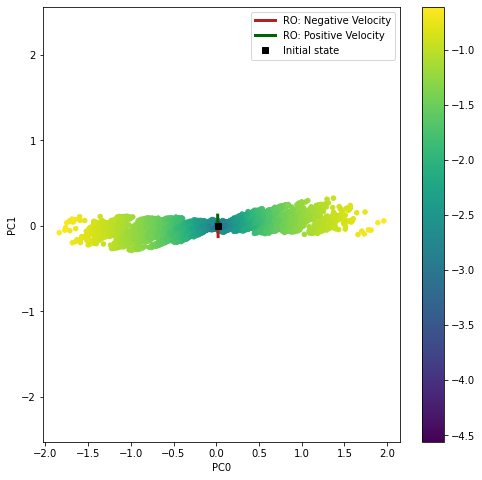

In [85]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
pca_fps = pca.transform(np.vstack(fixed_points)).T

pc1 = 0
pc2 = 1

fp_scatter = ax1.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
ro_labels = ['Negative Velocity', 'Positive Velocity']
for i in range(rnn_specs['output_size']):
    x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
    y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
    ax1.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, label=f'RO: {ro_labels[i]}')

ax1.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

ax1.set_xlabel('PC'+str(pc1))
ax1.set_ylabel('PC'+str(pc2))
plt_lim = None
if plt_lim != None:
    plt.xlim(-plt_lim, plt_lim)
    plt.ylim(-plt_lim, plt_lim)

ax1.set_aspect(1.0, adjustable='datalim')
ax1.legend()
fig.colorbar(fp_scatter, ax=ax1)

Text(0, 0.5, 'PC5')

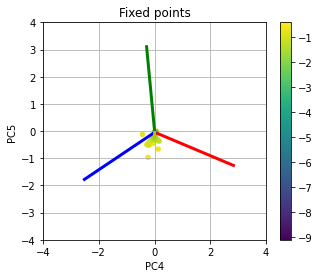

In [ ]:
# 2D Visualization of the approximate fixed points: the line attractor.

pc1 = 4
pc2 = 5

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
# pca_fps = pca.transform(np.vstack(hs_grid_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()

plt.colorbar()

# pca_word = 1*word_deflection('kinda0', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 1*word_deflection('kinda1', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout.shape[0]):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
# plt.plot(pca_h0[pc1], pca_h0[pc2], '*', color='k', ms=18)
plt.title('Fixed points')


plt_lim = 4
if plt_lim != None:
  plt.xlim(-plt_lim, plt_lim)
  plt.ylim(-plt_lim, plt_lim)
plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))

### Environment Stuff

#### Space Objects

In [11]:
from gym.utils import seeding


class Space(object):
    """Defines the observation and action spaces, so you can write generic
    code that applies to any Env. For example, you can choose a random
    action.
    WARNING - Custom observation & action spaces can inherit from the `Space`
    class. However, most use-cases should be covered by the existing space
    classes (e.g. `Box`, `Discrete`, etc...), and container classes (`Tuple` &
    `Dict`). Note that parametrized probability distributions (through the
    `sample()` method), and batching functions (in `gym.vector.VectorEnv`), are
    only well-defined for instances of spaces provided in gym by default.
    Moreover, some implementations of Reinforcement Learning algorithms might
    not handle custom spaces properly. Use custom spaces with care.
    """
    def __init__(self, shape=None, dtype=None):
        import numpy as np  # takes about 300-400ms to import, so we load lazily
        self.shape = None if shape is None else tuple(shape)
        self.dtype = None if dtype is None else np.dtype(dtype)
        self._np_random = None

    @property
    def np_random(self):
        """Lazily seed the rng since this is expensive and only needed if
        sampling from this space.
        """
        if self._np_random is None:
            self.seed()

        return self._np_random

    def sample(self):
        """Randomly sample an element of this space. Can be 
        uniform or non-uniform sampling based on boundedness of space."""
        raise NotImplementedError

    def seed(self, seed=None):
        """Seed the PRNG of this space. """
        self._np_random, seed = seeding.np_random(seed)
        return [seed]

    def contains(self, x):
        """
        Return boolean specifying if x is a valid
        member of this space
        """
        raise NotImplementedError

    def __contains__(self, x):
        return self.contains(x)

    def to_jsonable(self, sample_n):
        """Convert a batch of samples from this space to a JSONable data type."""
        # By default, assume identity is JSONable
        return sample_n

    def from_jsonable(self, sample_n):
        """Convert a JSONable data type to a batch of samples from this space."""
        # By default, assume identity is JSONable
        return sample_n

In [ ]:
import numpy as np
from .space import Space


class Discrete(Space):
    r"""A discrete space in :math:`\{ 0, 1, \\dots, n-1 \}`. 
    Example::
        >>> Discrete(2)
    """
    def __init__(self, n):
        assert n >= 0
        self.n = n
        super(Discrete, self).__init__((), np.int64)

    def sample(self):
        return self.np_random.randint(self.n)

    def contains(self, x):
        if isinstance(x, int):
            as_int = x
        elif isinstance(x, (np.generic, np.ndarray)) and (x.dtype.char in np.typecodes['AllInteger'] and x.shape == ()):
            as_int = int(x)
        else:
            return False
        return as_int >= 0 and as_int < self.n

    def __repr__(self):
        return "Discrete(%d)" % self.n

    def __eq__(self, other):
        return isinstance(other, Discrete) and self.n == other.n



In [ ]:
import numpy as np

from .space import Space
from gym import logger


class Box(Space):
    """
    A (possibly unbounded) box in R^n. Specifically, a Box represents the
    Cartesian product of n closed intervals. Each interval has the form of one
    of [a, b], (-oo, b], [a, oo), or (-oo, oo).
    There are two common use cases:
    * Identical bound for each dimension::
        >>> Box(low=-1.0, high=2.0, shape=(3, 4), dtype=np.float32)
        Box(3, 4)
    * Independent bound for each dimension::
        >>> Box(low=np.array([-1.0, -2.0]), high=np.array([2.0, 4.0]), dtype=np.float32)
        Box(2,)
    """
    def __init__(self, low, high, shape=None, dtype=np.float32):
        assert dtype is not None, 'dtype must be explicitly provided. '
        self.dtype = np.dtype(dtype)

        # determine shape if it isn't provided directly
        if shape is not None:
            shape = tuple(shape)
            assert np.isscalar(low) or low.shape == shape, "low.shape doesn't match provided shape"
            assert np.isscalar(high) or high.shape == shape, "high.shape doesn't match provided shape"
        elif not np.isscalar(low):
            shape = low.shape
            assert np.isscalar(high) or high.shape == shape, "high.shape doesn't match low.shape"
        elif not np.isscalar(high):
            shape = high.shape
            assert np.isscalar(low) or low.shape == shape, "low.shape doesn't match high.shape"
        else:
            raise ValueError("shape must be provided or inferred from the shapes of low or high")

        if np.isscalar(low):
            low = np.full(shape, low, dtype=dtype)

        if np.isscalar(high):
            high = np.full(shape, high, dtype=dtype)

        self.shape = shape
        self.low = low
        self.high = high

        def _get_precision(dtype):
            if np.issubdtype(dtype, np.floating):
                return np.finfo(dtype).precision
            else:
                return np.inf
        low_precision = _get_precision(self.low.dtype)
        high_precision = _get_precision(self.high.dtype)
        dtype_precision = _get_precision(self.dtype)
        if min(low_precision, high_precision) > dtype_precision:
            logger.warn("Box bound precision lowered by casting to {}".format(self.dtype))
        self.low = self.low.astype(self.dtype)
        self.high = self.high.astype(self.dtype)

        # Boolean arrays which indicate the interval type for each coordinate
        self.bounded_below = -np.inf < self.low
        self.bounded_above = np.inf > self.high

        super(Box, self).__init__(self.shape, self.dtype)

    def is_bounded(self, manner="both"):
        below = np.all(self.bounded_below)
        above = np.all(self.bounded_above)
        if manner == "both":
            return below and above
        elif manner == "below":
            return below
        elif manner == "above":
            return above
        else:
            raise ValueError("manner is not in {'below', 'above', 'both'}")

    def sample(self):
        """
        Generates a single random sample inside of the Box.
        In creating a sample of the box, each coordinate is sampled according to
        the form of the interval:
        * [a, b] : uniform distribution
        * [a, oo) : shifted exponential distribution
        * (-oo, b] : shifted negative exponential distribution
        * (-oo, oo) : normal distribution
        """
        high = self.high if self.dtype.kind == 'f' \
                else self.high.astype('int64') + 1
        sample = np.empty(self.shape)

        # Masking arrays which classify the coordinates according to interval
        # type
        unbounded   = ~self.bounded_below & ~self.bounded_above
        upp_bounded = ~self.bounded_below &  self.bounded_above
        low_bounded =  self.bounded_below & ~self.bounded_above
        bounded     =  self.bounded_below &  self.bounded_above


        # Vectorized sampling by interval type
        sample[unbounded] = self.np_random.normal(
                size=unbounded[unbounded].shape)

        sample[low_bounded] = self.np_random.exponential(
            size=low_bounded[low_bounded].shape) + self.low[low_bounded]

        sample[upp_bounded] = -self.np_random.exponential(
            size=upp_bounded[upp_bounded].shape) + self.high[upp_bounded]

        sample[bounded] = self.np_random.uniform(low=self.low[bounded],
                                            high=high[bounded],
                                            size=bounded[bounded].shape)
        if self.dtype.kind == 'i':
            sample = np.floor(sample)

        return sample.astype(self.dtype)

    def contains(self, x):
        if isinstance(x, list):
            x = np.array(x)  # Promote list to array for contains check
        return x.shape == self.shape and np.all(x >= self.low) and np.all(x <= self.high)

    def to_jsonable(self, sample_n):
        return np.array(sample_n).tolist()

    def from_jsonable(self, sample_n):
        return [np.asarray(sample) for sample in sample_n]

    def __repr__(self):
        return "Box({}, {}, {}, {})".format(self.low.min(), self.high.max(), self.shape, self.dtype)

    def __eq__(self, other):
        return isinstance(other, Box) and (self.shape == other.shape) and np.allclose(self.low, other.low) and np.allclose(self.high, other.high)

#### Environment Object

In [17]:
class Env(object):
    """The main OpenAI Gym class. It encapsulates an environment with
    arbitrary behind-the-scenes dynamics. An environment can be
    partially or fully observed.
    The main API methods that users of this class need to know are:
        step
        reset
        render
        close
        seed
    And set the following attributes:
        action_space: The Space object corresponding to valid actions
        observation_space: The Space object corresponding to valid observations
        reward_range: A tuple corresponding to the min and max possible rewards
    Note: a default reward range set to [-inf,+inf] already exists. Set it if you want a narrower range.
    The methods are accessed publicly as "step", "reset", etc...
    """
    # Set this in SOME subclasses
    metadata = {'render.modes': []}
    reward_range = (-float('inf'), float('inf'))
    spec = None

    # Set these in ALL subclasses
    action_space = None
    observation_space = None

    def step(self, action):
        """Run one timestep of the environment's dynamics. When end of
        episode is reached, you are responsible for calling `reset()`
        to reset this environment's state.
        Accepts an action and returns a tuple (observation, reward, done, info).
        Args:
            action (object): an action provided by the agent
        Returns:
            observation (object): agent's observation of the current environment
            reward (float) : amount of reward returned after previous action
            done (bool): whether the episode has ended, in which case further step() calls will return undefined results
            info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
        """
        raise NotImplementedError

    def reset(self):
        """Resets the environment to an initial state and returns an initial
        observation.
        Note that this function should not reset the environment's random
        number generator(s); random variables in the environment's state should
        be sampled independently between multiple calls to `reset()`. In other
        words, each call of `reset()` should yield an environment suitable for
        a new episode, independent of previous episodes.
        Returns:
            observation (object): the initial observation.
        """
        raise NotImplementedError

    def render(self, mode='human'):
        """Renders the environment.
        The set of supported modes varies per environment. (And some
        environments do not support rendering at all.) By convention,
        if mode is:
        - human: render to the current display or terminal and
          return nothing. Usually for human consumption.
        - rgb_array: Return an numpy.ndarray with shape (x, y, 3),
          representing RGB values for an x-by-y pixel image, suitable
          for turning into a video.
        - ansi: Return a string (str) or StringIO.StringIO containing a
          terminal-style text representation. The text can include newlines
          and ANSI escape sequences (e.g. for colors).
        Note:
            Make sure that your class's metadata 'render.modes' key includes
              the list of supported modes. It's recommended to call super()
              in implementations to use the functionality of this method.
        Args:
            mode (str): the mode to render with
        Example:
        class MyEnv(Env):
            metadata = {'render.modes': ['human', 'rgb_array']}
            def render(self, mode='human'):
                if mode == 'rgb_array':
                    return np.array(...) # return RGB frame suitable for video
                elif mode == 'human':
                    ... # pop up a window and render
                else:
                    super(MyEnv, self).render(mode=mode) # just raise an exception
        """
        raise NotImplementedError

    def close(self):
        """Override close in your subclass to perform any necessary cleanup.
        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        pass

    def seed(self, seed=None):
        """Sets the seed for this env's random number generator(s).
        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.
        Returns:
            list<bigint>: Returns the list of seeds used in this env's random
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        return

    @property
    def unwrapped(self):
        """Completely unwrap this env.
        Returns:
            gym.Env: The base non-wrapped gym.Env instance
        """
        return self

    def __str__(self):
        if self.spec is None:
            return '<{} instance>'.format(type(self).__name__)
        else:
            return '<{}<{}>>'.format(type(self).__name__, self.spec.id)

    def __enter__(self):
        """Support with-statement for the environment. """
        return self

    def __exit__(self, *args):
        """Support with-statement for the environment. """
        self.close()
        # propagate exception
        return False

#### Cart-Pole Environment

In [18]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""


class CartPoleEnv(Env):
    """
    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
    Reward:
        Reward is 1 for every step taken, including the termination step
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
        Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.
    """

    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = 'euler'

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * jnp.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = jnp.array([self.x_threshold * 2,
                          jnp.finfo(jnp.float32).max,
                          self.theta_threshold_radians * 2,
                          jnp.finfo(jnp.float32).max],
                         dtype=jnp.float32)

        # self.action_space = spaces.Discrete(2)
        # self.observation_space = spaces.Box(-high, high, dtype=np.float32)
        self.action_space = 2
        self.observation_space = 4

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    # def seed(self, seed=None):
    #     self.np_random, seed = seeding.np_random(seed)
    #     return [seed]

    def step(self, state, action):
        # err_msg = "%r (%s) invalid" % (action, type(action))
        # assert self.action_space.contains(action), err_msg

        # x, x_dot, theta, theta_dot = self.state[:, 0], self.state[:, 1], self.state[:, 2], self.state[:, 3]
        x, x_dot, theta, theta_dot = state[:, 0], state[:, 1], state[:, 2], state[:, 3]

        force = self.force_mag * (2 * action - 1)
        # force = self.force_mag if action == 1 else -self.force_mag
        costheta = jnp.cos(theta)
        sintheta = jnp.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = jnp.concatenate((x[:, jnp.newaxis], x_dot[:, jnp.newaxis], 
                                      theta[:, jnp.newaxis], 
                                      theta_dot[:, jnp.newaxis]), axis=1)

        done_cond = jnp.logical_or(
            jnp.logical_or(x < -self.x_threshold, x > self.x_threshold),
            jnp.logical_or(theta < -self.theta_threshold_radians, 
                           theta > self.theta_threshold_radians))
        
        # done = jnp.logical_or(self.steps_beyond_done > 0.0, done_cond)
        done = done_cond

        # # Reward if not done OR steps_beyond_done = 0.0 (first failure gets reward)
        # reward = jnp.logical_or(jnp.logical_not(done), self.steps_beyond_done == 0.0)
        # Reward if not done
        # reward = 2 * jnp.int32(jnp.logical_not(done)) - 1
        reward = jnp.int32(jnp.logical_not(done))

        # self.steps_beyond_done = self.steps_beyond_done + done

        # if not done:
        #     reward = 1.0
        # elif self.steps_beyond_done is None:
        #     # Pole just fell!
        #     self.steps_beyond_done = 0
        #     reward = 1.0
        # else:
        #     # if self.steps_beyond_done == 0:
        #     #     logger.warn(
        #     #         "You are calling 'step()' even though this "
        #     #         "environment has already returned done = True. You "
        #     #         "should always call 'reset()' once you receive 'done = "
        #     #         "True' -- any further steps are undefined behavior."
        #     #     )
        #     self.steps_beyond_done += 1
        #     reward = 0.0

        return jnp.array(self.state), reward, done, {}

    def reset(self, prng_key, batch_size):
        # self.state = jax.random.uniform(prng_key, minval=-0.05, maxval=0.05, shape=(batch_size, 4,))
        # self.state = np.random.uniform(low=-0.05, high=0.05, size=(batch_size, 4,))
        self.steps_beyond_done = jnp.zeros((batch_size))
        return jax.random.uniform(prng_key, minval=-0.05, maxval=0.05, shape=(batch_size, 4,))

    # def render(self, mode='human'):
    #     screen_width = 600
    #     screen_height = 400

    #     world_width = self.x_threshold * 2
    #     scale = screen_width/world_width
    #     carty = 100  # TOP OF CART
    #     polewidth = 10.0
    #     polelen = scale * (2 * self.length)
    #     cartwidth = 50.0
    #     cartheight = 30.0

    #     if self.viewer is None:
    #         from gym.envs.classic_control import rendering
    #         self.viewer = rendering.Viewer(screen_width, screen_height)
    #         l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
    #         axleoffset = cartheight / 4.0
    #         cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
    #         self.carttrans = rendering.Transform()
    #         cart.add_attr(self.carttrans)
    #         self.viewer.add_geom(cart)
    #         l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
    #         pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
    #         pole.set_color(.8, .6, .4)
    #         self.poletrans = rendering.Transform(translation=(0, axleoffset))
    #         pole.add_attr(self.poletrans)
    #         pole.add_attr(self.carttrans)
    #         self.viewer.add_geom(pole)
    #         self.axle = rendering.make_circle(polewidth/2)
    #         self.axle.add_attr(self.poletrans)
    #         self.axle.add_attr(self.carttrans)
    #         self.axle.set_color(.5, .5, .8)
    #         self.viewer.add_geom(self.axle)
    #         self.track = rendering.Line((0, carty), (screen_width, carty))
    #         self.track.set_color(0, 0, 0)
    #         self.viewer.add_geom(self.track)

    #         self._pole_geom = pole

    #     if self.state is None:
    #         return None

    #     # Edit the pole polygon vertex
    #     pole = self._pole_geom
    #     l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
    #     pole.v = [(l, b), (l, t), (r, t), (r, b)]

    #     x = self.state
    #     cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
    #     self.carttrans.set_translation(cartx, carty)
    #     self.poletrans.set_rotation(-x[2])

    #     return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    # def close(self):
    #     if self.viewer:
    #         self.viewer.close()
    #         self.viewer = None


In [153]:
'''
Observation:
    Type: Box(4)
    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole 
                    -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf
Actions:
    Type: Discrete(2)
    Num   Action
    0     Push cart to the left
    1     Push cart to the right
'''

env = CartPoleEnv()
action_space_dim = env.action_space
state_space_dim = env.observation_space

env.max_episode_steps = 500
print('Action space size:', action_space)
print('State space size:', state_space)

def batch_state(state):
    return state.reshape((1,) + state.shape)

Action space size: 2
State space size: 4


In [137]:
seed = np.random.randint(0, 999999) #342343
prng_key = jax.random.PRNGKey(seed)

time_length = 100
n_batch = 2
states = np.zeros((n_batch, time_length+1, 4))

start_state = env.reset(prng_key, n_batch)
print('Start state:', start_state)
states[:, 0, :] = start_state
for idx in range(time_length):
    rand_action = np.random.randint(action_space, size=(n_batch,))
    # print('Rand action shape:', rand_action.shape)
    next_state, reward, done, _ = env.step(states[:, idx, :], rand_action)
    # print(next_state.shape)
    states[:, idx+1, :] = next_state
    print('New state:', next_state, 'Reward', reward, 'Done:', done)


Start state: [[-0.02730711  0.04849358  0.04277826  0.03882127]
 [-0.00354968 -0.04265961 -0.02148995  0.04175569]]
New state: [[-0.02633723 -0.14721486  0.04355469  0.34468833]
 [-0.00440288  0.1527638  -0.02065484 -0.2576293 ]] Reward [1 1] Done: [False False]
New state: [[-0.02928153  0.0472613   0.05044845  0.06605178]
 [-0.0013476   0.34817442 -0.02580743 -0.55675477]] Reward [1 1] Done: [False False]
New state: [[-0.02833631 -0.14854626  0.05176949  0.37421498]
 [ 0.00561589  0.15342411 -0.03694252 -0.27231318]] Reward [1 1] Done: [False False]
New state: [[-0.03130723 -0.34436387  0.05925379  0.6827613 ]
 [ 0.00868437 -0.04115176 -0.04238879  0.00849286]] Reward [1 1] Done: [False False]
New state: [[-0.03819451 -0.5402564   0.07290901  0.99349487]
 [ 0.00786134 -0.23564097 -0.04221893  0.287506  ]] Reward [1 1] Done: [False False]
New state: [[-0.04899963 -0.34618157  0.09277891  0.7245723 ]
 [ 0.00314852 -0.4301362  -0.03646881  0.5665802 ]] Reward [1 1] Done: [False False]
Ne

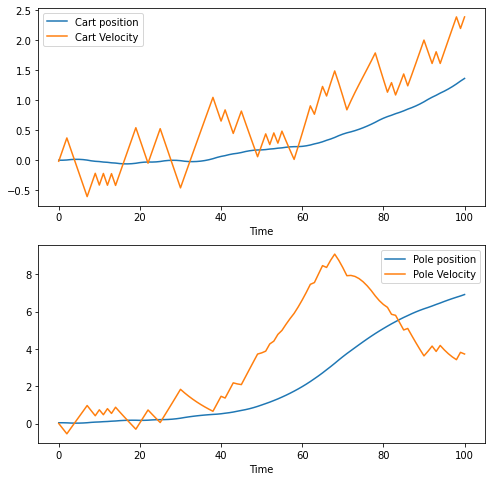

In [285]:
batch_idx = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(np.arange(time_length+1), states[batch_idx, :, 0], label='Cart position')
ax1.plot(np.arange(time_length+1), states[batch_idx, :, 1], label='Cart Velocity')
ax2.plot(np.arange(time_length+1), states[batch_idx, :, 2], label='Pole position')
ax2.plot(np.arange(time_length+1), states[batch_idx, :, 3], label='Pole Velocity')

for ax in (ax1, ax2):
    ax.legend()
    ax.set_xlabel('Time')

#### Cart-Pole with Stay

In [92]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""


class CartPoleStayEnv(Env):
    """
    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(3)
        Num   Action
        0     Push cart to the left
        1     No push to cart
        2     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
    Reward:
        Reward is 1 for every step taken, including the termination step
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
        Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.
    """

    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = 'euler'

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * jnp.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = jnp.array([self.x_threshold * 2,
                          jnp.finfo(jnp.float32).max,
                          self.theta_threshold_radians * 2,
                          jnp.finfo(jnp.float32).max],
                         dtype=jnp.float32)

        # self.action_space = spaces.Discrete(2)
        # self.observation_space = spaces.Box(-high, high, dtype=np.float32)
        self.action_space = 3
        self.observation_space = 4

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None


    def step(self, state, action):
        # err_msg = "%r (%s) invalid" % (action, type(action))
        # assert self.action_space.contains(action), err_msg

        # x, x_dot, theta, theta_dot = self.state[:, 0], self.state[:, 1], self.state[:, 2], self.state[:, 3]
        x, x_dot, theta, theta_dot = state[:, 0], state[:, 1], state[:, 2], state[:, 3]

        force = self.force_mag * (action - 1)
        # force = self.force_mag if action == 1 else -self.force_mag
        costheta = jnp.cos(theta)
        sintheta = jnp.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = jnp.concatenate((x[:, jnp.newaxis], x_dot[:, jnp.newaxis], 
                                      theta[:, jnp.newaxis], 
                                      theta_dot[:, jnp.newaxis]), axis=1)

        done_cond = jnp.logical_or(
            jnp.logical_or(x < -self.x_threshold, x > self.x_threshold),
            jnp.logical_or(theta < -self.theta_threshold_radians, 
                           theta > self.theta_threshold_radians))
        
        # done = jnp.logical_or(self.steps_beyond_done > 0.0, done_cond)
        done = done_cond

        # # Reward if not done OR steps_beyond_done = 0.0 (first failure gets reward)
        # reward = jnp.logical_or(jnp.logical_not(done), self.steps_beyond_done == 0.0)
        # Reward if not done
        # reward = 2 * jnp.int32(jnp.logical_not(done)) - 1
        reward = jnp.int32(jnp.logical_not(done))

        return jnp.array(self.state), reward, done, {}

    def reset(self, prng_key, batch_size):
        # self.state = jax.random.uniform(prng_key, minval=-0.05, maxval=0.05, shape=(batch_size, 4,))
        # self.state = np.random.uniform(low=-0.05, high=0.05, size=(batch_size, 4,))
        self.steps_beyond_done = jnp.zeros((batch_size))
        return jax.random.uniform(prng_key, minval=-0.05, maxval=0.05, shape=(batch_size, 4,))


In [88]:
'''
Observation:
    Type: Box(4)
    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole 
                    -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf
Actions:
    Type: Discrete(2)
    Num   Action
    0     Push cart to the left
    1     No push to cart
    2     Push cart to the right
'''

env = CartPoleStayEnv()
action_space_dim = env.action_space
state_space_dim = env.observation_space

env.max_episode_steps = 500
print('Action space size:', action_space)
print('State space size:', state_space)

seed = np.random.randint(0, 999999) #342343
prng_key = jax.random.PRNGKey(seed)

time_length = 100
n_batch = 2
states = np.zeros((n_batch, time_length+1, 4))

start_state = env.reset(prng_key, n_batch)
print('Start state:', start_state)
states[:, 0, :] = start_state
for idx in range(time_length):
    rand_action = np.random.randint(action_space, size=(n_batch,))
    # print('Rand action shape:', rand_action.shape)
    next_state, reward, done, _ = env.step(states[:, idx, :], rand_action)
    # print(next_state.shape)
    states[:, idx+1, :] = next_state
    print('New state:', next_state, 'Reward', reward, 'Done:', done)

Action space size: 2
State space size: 4
Start state: [[ 0.01115599 -0.01826475 -0.03975401  0.04330165]
 [-0.02087166  0.01753668  0.02608473 -0.02883235]]
New state: [[ 0.01079069 -0.01769535 -0.03888798  0.03076364]
 [-0.02052093  0.01716279  0.02550809 -0.02060368]] Reward [1 1] Done: [False False]
New state: [[ 0.01043679 -0.0171383  -0.0382727   0.01849851]
 [-0.02017767  0.01679716  0.02509601 -0.01255683]] Reward [1 1] Done: [False False]
New state: [[ 0.01009402 -0.01659003 -0.03790274  0.00642727]
 [-0.01984173  0.01643741  0.02484488 -0.00463994]] Reward [1 1] Done: [False False]
New state: [[ 0.00976222 -0.21114847 -0.03777419  0.28691456]
 [-0.01951298  0.01608126  0.02475208  0.00319776]] Reward [1 1] Done: [False False]
New state: [[ 0.00553925 -0.21061035 -0.0320359   0.27500495]
 [-0.01919136  0.01572644  0.02481603  0.0110062 ]] Reward [1 1] Done: [False False]
New state: [[ 0.00132704 -0.4052609  -0.0265358   0.55741405]
 [-0.01887683  0.01537071  0.02503616  0.01883

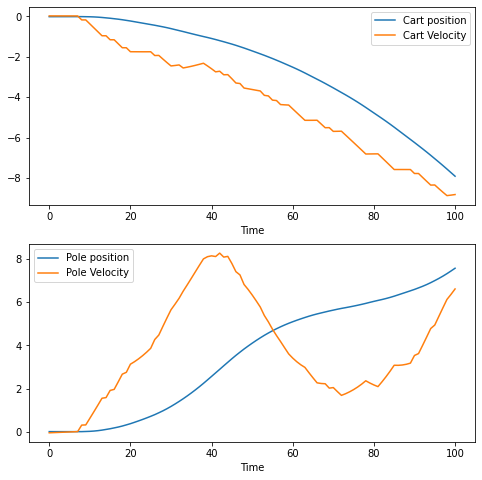

In [90]:
batch_idx = 1
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(np.arange(time_length+1), states[batch_idx, :, 0], label='Cart position')
ax1.plot(np.arange(time_length+1), states[batch_idx, :, 1], label='Cart Velocity')
ax2.plot(np.arange(time_length+1), states[batch_idx, :, 2], label='Pole position')
ax2.plot(np.arange(time_length+1), states[batch_idx, :, 3], label='Pole Velocity')

for ax in (ax1, ax2):
    ax.legend()
    ax.set_xlabel('Time')